## Este notebook foi finalizado por Camilly Alves
* O projeto se concentra na aplicação do modelo Prophet para previsão de séries temporais, explorando diferentes configurações de hiperparâmetros para otimizar as previsões. Através da validação de múltiplos modelos, o trabalho busca identificar a abordagem mais eficaz, oferecendo uma visão prática das técnicas de modelagem de séries temporais.

# Prophet Facebook
* https://facebook.github.io/prophet/docs/quick_start.html



# Install

In [1]:
pip install prophet

In [2]:
from prophet import Prophet

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import itertools

#TimeSeries
from prophet import Prophet #case sensitive, needs to be Prophet with capital "P"
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',200)
pd.set_option('display.width',1000)

# Load Datasets

In [4]:
# Vamos importar a base para o nosso notebook e dar uma primeira "olhada" nos dados:
ts_raw = pd.read_csv('https://raw.githubusercontent.com/abnr/ml-data/main/stocks_ABBV.csv', index_col=[0])
ts_raw

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-11-23,85.599998,86.550003,84.900002,85.629997,78.807220,1612800
1,2013-12-24,52.779999,52.790001,52.279999,52.360001,40.406071,1747000
2,2019-12-24,90.400002,90.400002,89.430000,89.849998,88.652267,1798800
3,2017-12-28,98.190002,98.389999,97.519997,97.790001,86.620544,1870400
4,2017-12-27,97.730003,98.230003,97.440002,98.089996,86.886284,1927300
...,...,...,...,...,...,...,...
1820,2015-10-22,53.880001,54.439999,45.450001,48.270000,39.716072,46517700
1821,2015-03-05,57.209999,59.480000,56.650002,56.860001,45.636005,47051800
1822,2014-10-16,55.799999,55.900002,52.840000,52.900002,42.141338,61236700
1823,2019-06-25,70.470001,70.669998,65.059998,65.699997,62.018341,90131800


# Prophet
* https://facebook.github.io/prophet/docs/

In [5]:
# Vamos separar agora apenas os dados de fechamento, e estuda-la como uma série temporal
ts = ts_raw[['Date', 'Close']].copy()

# Renomeando as features para o padrão exigido pelo prophet
ts.rename(columns = {'Date':'ds',
                     'Close':'y'}, inplace = True)

#transformando ds para datetime
ts['ds'] = pd.to_datetime(ts['ds'])
ts = ts.sort_values('ds')
display(ts.head())
display(ts.tail())

,ds,y
1676,2013-01-02,35.119999
1743,2013-01-03,34.830002
1792,2013-01-04,34.389999
1759,2013-01-07,34.459999
1757,2013-01-08,33.709999


,ds,y
1730,2020-03-26,73.830002
1613,2020-03-27,72.669998
1508,2020-03-30,75.239998
1785,2020-03-31,76.190002
1648,2020-04-01,73.419998


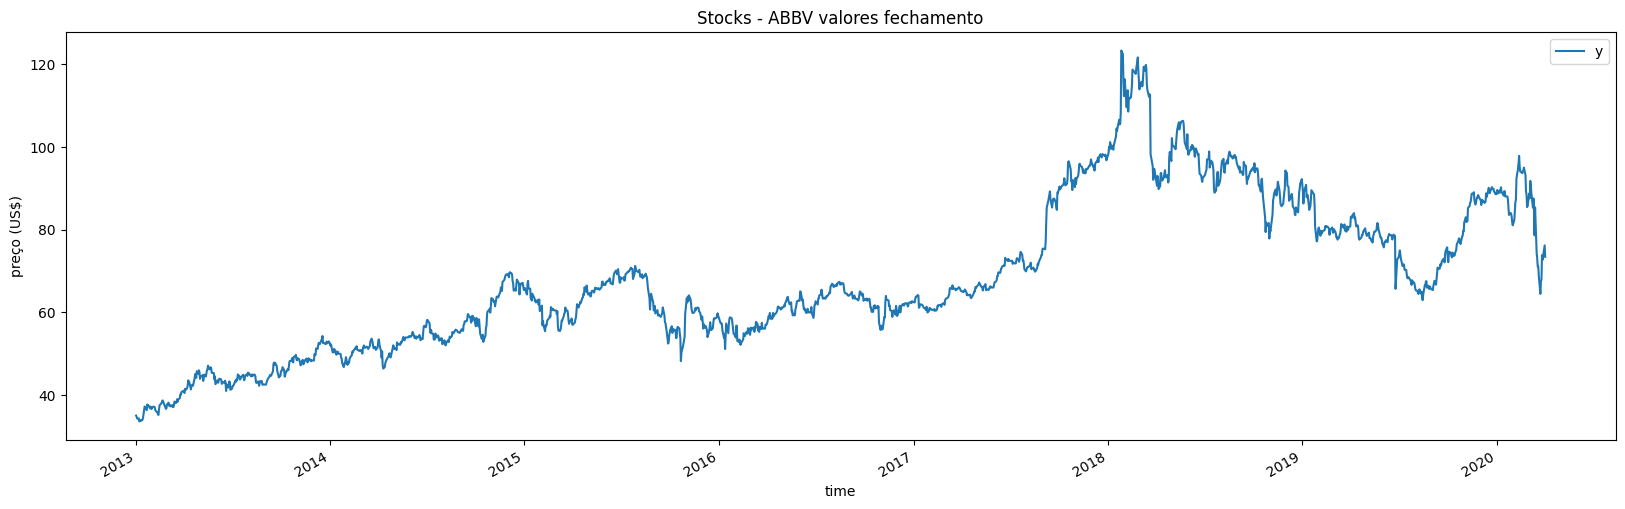

In [6]:
df_plot = ts.copy()
df_plot.set_index('ds', inplace = True)
df_plot.plot(figsize=(20, 6))

plt.title('Stocks - ABBV valores fechamento')
plt.ylabel('preço (US$)')
plt.xlabel('time');

# Modeling

## Utilizando o df completo para o fit do modelo

In [7]:
display(ts.shape)
display('Tail do dataframe original: ',ts.tail() )

(1825, 2)

'Tail do dataframe original: '

,ds,y
1730,2020-03-26,73.830002
1613,2020-03-27,72.669998
1508,2020-03-30,75.239998
1785,2020-03-31,76.190002
1648,2020-04-01,73.419998


## m0

In [8]:
#instanciando o modelo
m0 = Prophet()
m0.fit(ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/c2h1hj6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/s40aw3jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95656', 'data', 'file=/tmp/tmp82pr4_27/c2h1hj6x.json', 'init=/tmp/tmp82pr4_27/s40aw3jf.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modeli6yu_xtf/prophet_model-20241028001518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:15:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:15:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [9]:
#criando os timestamps futuros para receber as previsões
future = m0.make_future_dataframe(periods=365, include_history=False)
print('Forecast excluindo histórico de treinamento: ', future.shape)
display('Head dos primeiros 5 timestamps de 365 no total: ', future.head(5))

future = m0.make_future_dataframe(periods=365, include_history=True)
print('\nForecast incluindo histórico: ', future.shape)
display('Tail dos últimos 5 timestamps de 365 no total: ', future.tail(5))

Forecast excluindo histórico de treinamento:  (365, 1)


'Head dos primeiros 5 timestamps de 365 no total: '

,ds
0,2020-04-02
1,2020-04-03
2,2020-04-04
3,2020-04-05
4,2020-04-06



Forecast incluindo histórico:  (2190, 1)


'Tail dos últimos 5 timestamps de 365 no total: '

,ds
2185,2021-03-28
2186,2021-03-29
2187,2021-03-30
2188,2021-03-31
2189,2021-04-01


In [10]:
#gerando as previsões para os timestamps criados na célula anterior
forecast = m0.predict(future)
display('Tail das últimas 5 previsões: ', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

'Tail das últimas 5 previsões: '

,ds,yhat,yhat_lower,yhat_upper
2185,2021-03-28,67.995491,49.857342,84.614649
2186,2021-03-29,68.911172,49.969121,85.704160
2187,2021-03-30,68.702257,49.446461,85.722214
2188,2021-03-31,68.639212,50.754321,86.018511
2189,2021-04-01,68.610415,49.765297,86.005194


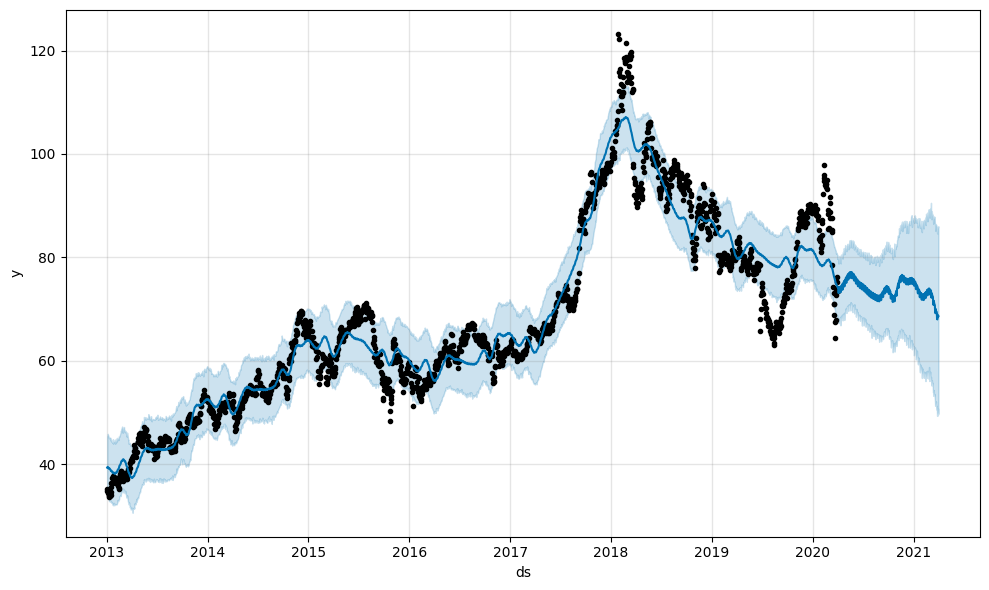

In [11]:
fig1 = m0.plot(forecast)

'\nweekly_start Integer specifying the start day of the weekly seasonality plot. 0 (default) starts\nthe week on Sunday. 1 shifts by 1 day to Monday, and so on.\n\nyearly_start Integer specifying the start day of the yearly seasonality plot. 0 (default) starts\nthe year on Jan 1. 1 shifts by 1 day to Jan 2, and so on\n'

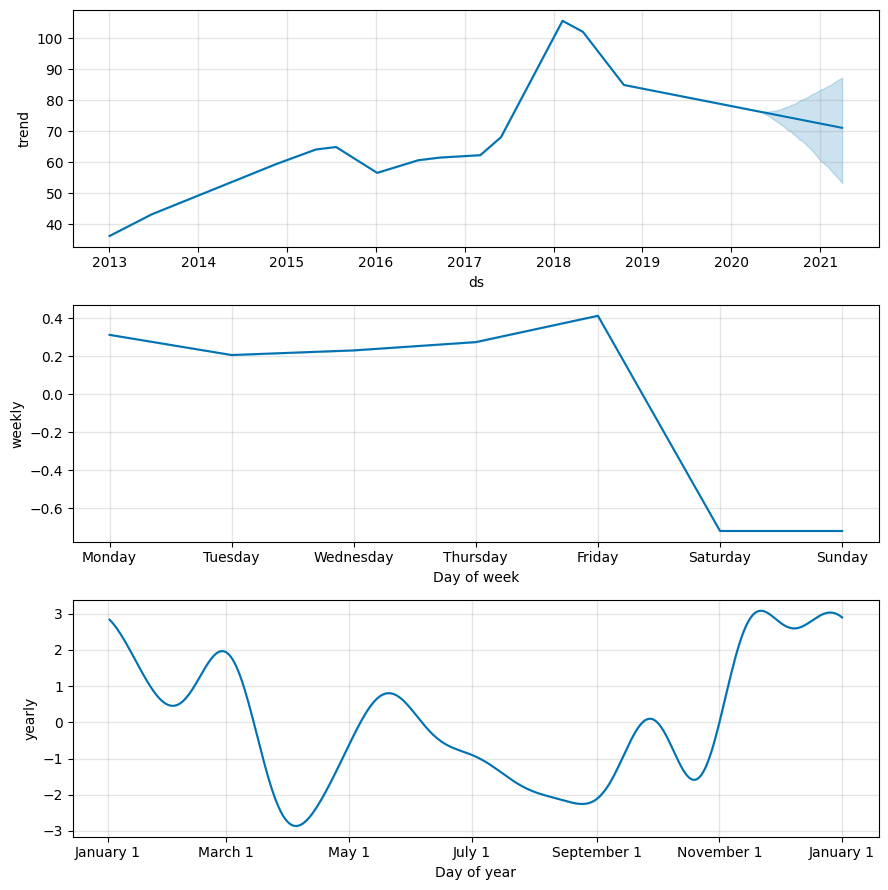

In [12]:
#componentes
fig2 = m0.plot_components( forecast,
                          uncertainty = True,
                          plot_cap = True,
                          weekly_start = 1,
                          yearly_start = 1,
                          )
'''
weekly_start Integer specifying the start day of the weekly seasonality plot. 0 (default) starts
the week on Sunday. 1 shifts by 1 day to Monday, and so on.

yearly_start Integer specifying the start day of the yearly seasonality plot. 0 (default) starts
the year on Jan 1. 1 shifts by 1 day to Jan 2, and so on
'''

In [13]:
#componentes com plotly
from prophet.plot import plot_plotly, plot_components_plotly

fig1 = plot_plotly(m0, forecast)
fig1.show()

fig2 = plot_components_plotly(m0, forecast)
fig2.show()

# Changepoints
* Séries temporais reais frequentemente apresentam mudanças abruptas em suas trajetórias. Por padrão, o Prophet detectará automaticamente esses pontos de mudança e permitirá que a tendência se adapte adequadamente.

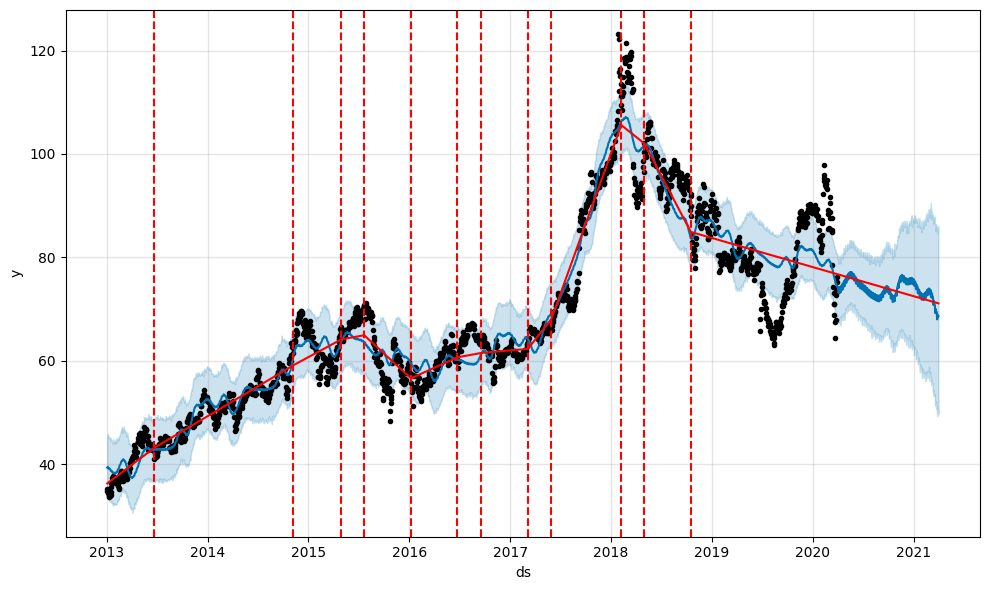

In [14]:
#changepoints

from prophet.plot import add_changepoints_to_plot
fig = m0.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m0, forecast)

## m1

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/9lq00_ij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/fgejm_nr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98013', 'data', 'file=/tmp/tmp82pr4_27/9lq00_ij.json', 'init=/tmp/tmp82pr4_27/fgejm_nr.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_model8l3murs6/prophet_model-20241028001627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:16:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


'\nO parâmetro changepoint_prior_scale é um hiperparâmetro importante no contexto do Prophet, que é uma ferramenta de previsão de séries temporais\ndesenvolvida pelo Facebook.\nEsse parâmetro controla a flexibilidade do modelo na detecção de mudanças abruptas nos dados de séries temporais.\nEm essência, ele controla a penalização aplicada às mudanças na tendência da série temporal.\n\nAqui estão os detalhes de como o parâmetro changepoint_prior_scale afeta o modelo Prophet:\n\nValores Baixos: Quando você define um valor baixo para changepoint_prior_scale, o modelo será mais conservador na detecção de mudanças.\nIsso significa que ele considerará menos pontos de dados como pontos de virada significativos na série temporal.\nO resultado pode ser um modelo que se ajusta melhor a séries temporais com mudanças suaves e graduais na tendência.\n\nValores Elevados: Por outro lado, se você definir um valor alto para changepoint_prior_scale, o modelo será mais flexível na detecção de mudanças.\n

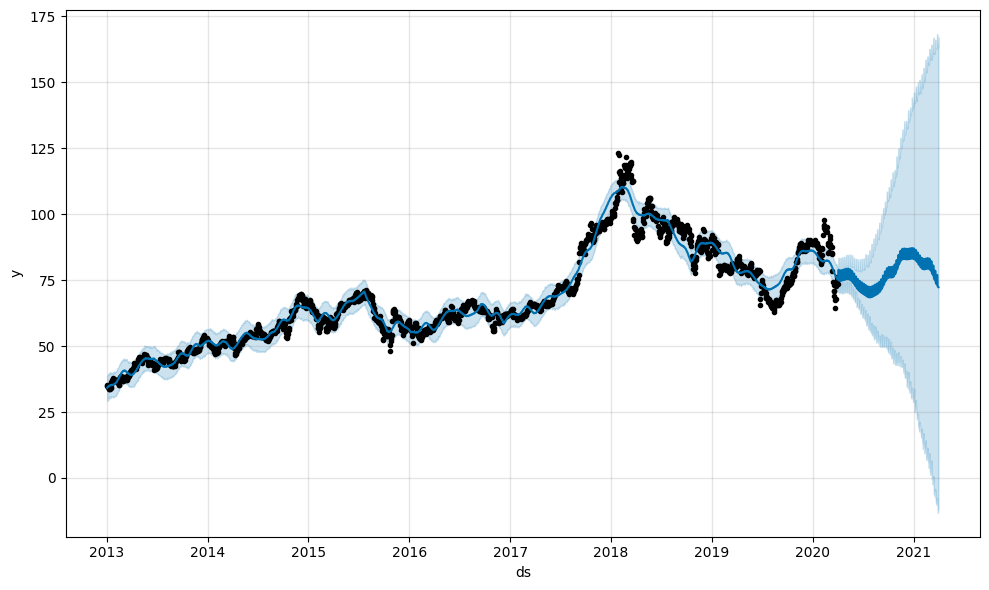

In [15]:
# changepoint_prior_scale = 0.5
m1 = Prophet(changepoint_prior_scale=0.5)
forecast = m1.fit(ts).predict(future)
fig = m1.plot(forecast)

'''
O parâmetro changepoint_prior_scale é um hiperparâmetro importante no contexto do Prophet, que é uma ferramenta de previsão de séries temporais
desenvolvida pelo Facebook.
Esse parâmetro controla a flexibilidade do modelo na detecção de mudanças abruptas nos dados de séries temporais.
Em essência, ele controla a penalização aplicada às mudanças na tendência da série temporal.

Aqui estão os detalhes de como o parâmetro changepoint_prior_scale afeta o modelo Prophet:

Valores Baixos: Quando você define um valor baixo para changepoint_prior_scale, o modelo será mais conservador na detecção de mudanças.
Isso significa que ele considerará menos pontos de dados como pontos de virada significativos na série temporal.
O resultado pode ser um modelo que se ajusta melhor a séries temporais com mudanças suaves e graduais na tendência.

Valores Elevados: Por outro lado, se você definir um valor alto para changepoint_prior_scale, o modelo será mais flexível na detecção de mudanças.
Ele considerará mais pontos de dados como potenciais pontos de virada, tornando-se mais sensível a flutuações nos dados.
Isso pode levar a um modelo que se ajusta bem a séries temporais com mudanças abruptas e irregulares na tendência.

A escolha apropriada do valor para changepoint_prior_scale depende da natureza dos dados da sua série temporal.
Se você souber que a série temporal possui mudanças bruscas e imprevisíveis, pode ser apropriado usar um valor baixo para tornar o modelo mais conservador.
Por outro lado, se as mudanças na série temporal forem frequentes e irregulares, um valor mais alto pode ser mais adequado.

Em geral, é uma boa prática ajustar o changepoint_prior_scale durante o processo de ajuste do modelo Prophet para encontrar o valor que melhor
se adapta aos seus dados específicos, usando validação cruzada ou outros métodos de otimização.
Experimentar diferentes valores e avaliar o desempenho do modelo em dados de validação ou teste pode ajudar a determinar o valor ideal
para esse parâmetro.
'''

## m2

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/wzfx8mwd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/0ou0pwsa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43793', 'data', 'file=/tmp/tmp82pr4_27/wzfx8mwd.json', 'init=/tmp/tmp82pr4_27/0ou0pwsa.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modelgzdip6_2/prophet_model-20241028001633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:16:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:16:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


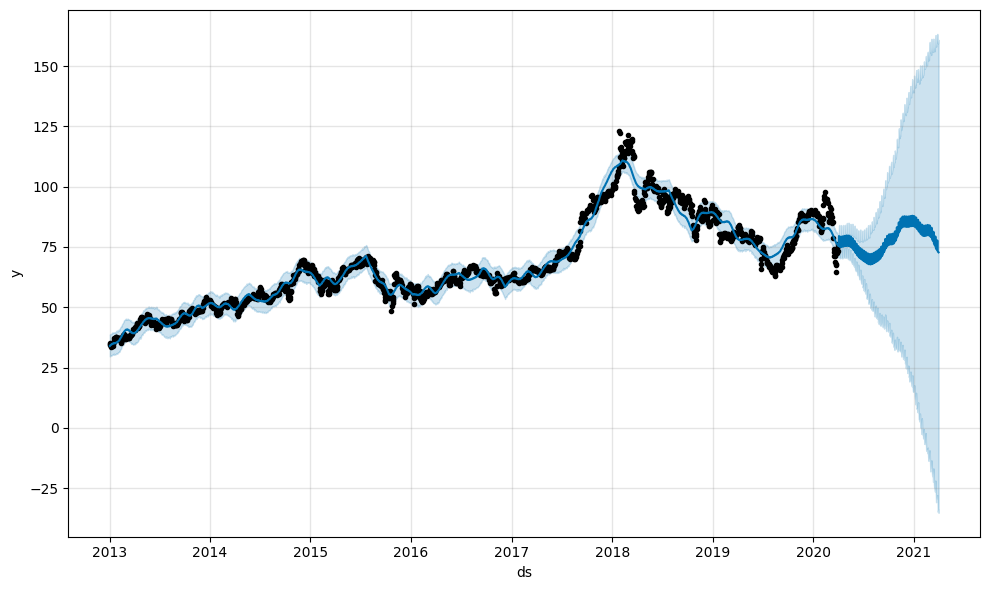

In [16]:
# changepoint_prior_scale = 0.001
# decreasing it will make the trend less flexible

m2 = Prophet(changepoint_prior_scale=0.99)
forecast = m2.fit(ts).predict(future)

fig = m2.plot(forecast)

# Specifying the locations of the changepoints

## m3

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/ps_x9y1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/wy0zwf67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69220', 'data', 'file=/tmp/tmp82pr4_27/ps_x9y1a.json', 'init=/tmp/tmp82pr4_27/wy0zwf67.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modelxame86p5/prophet_model-20241028001642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:16:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:16:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'Changepoints = 2019-08')

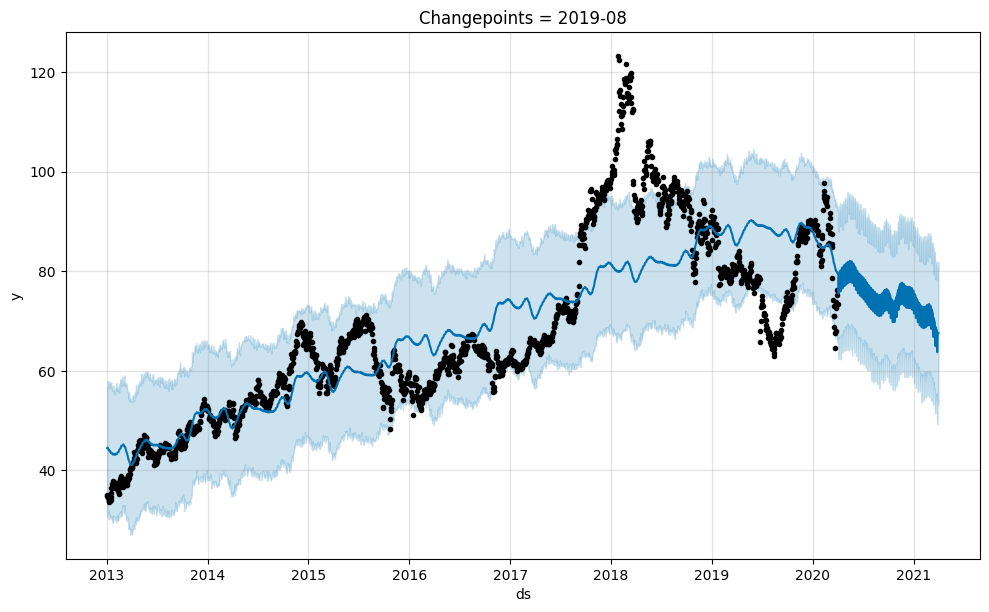

In [17]:
m3 = Prophet(changepoints=['2019-08'])
forecast = m3.fit(ts).predict(future)
fig = m3.plot(forecast)
plt.title('Changepoints = 2019-08')

## m4

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/nto4glum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/isv8_x1z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60724', 'data', 'file=/tmp/tmp82pr4_27/nto4glum.json', 'init=/tmp/tmp82pr4_27/isv8_x1z.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modelyd86c5kw/prophet_model-20241028001643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:16:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:16:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'Changepoints = 2018-01')

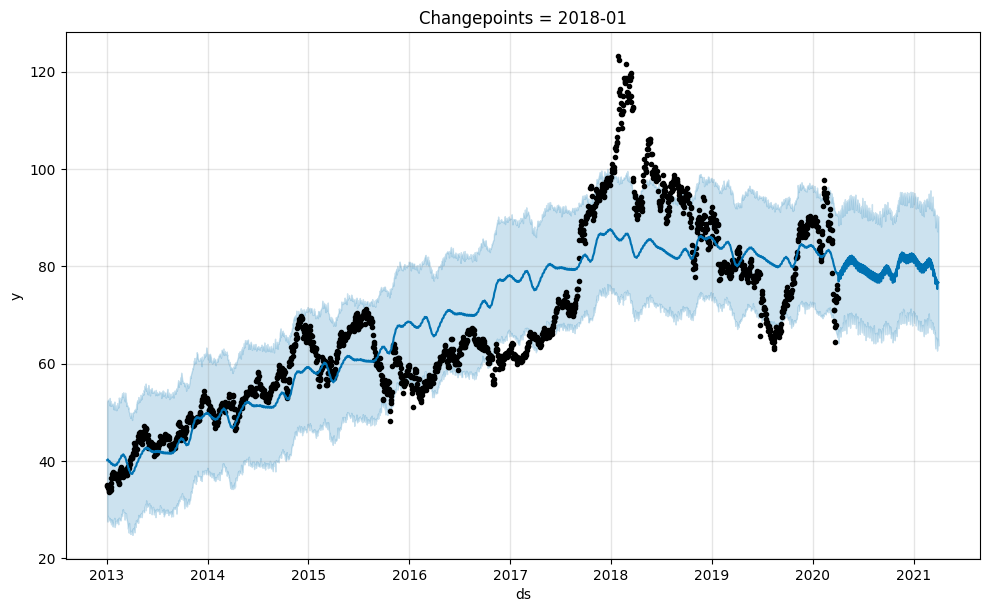

In [18]:
m4 = Prophet(changepoints=['2018-01'])
forecast = m4.fit(ts).predict(future)
fig = m4.plot(forecast)
plt.title('Changepoints = 2018-01')

## m5

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/tv4vmr68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/volwukck.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46741', 'data', 'file=/tmp/tmp82pr4_27/tv4vmr68.json', 'init=/tmp/tmp82pr4_27/volwukck.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_model_wcpujun/prophet_model-20241028002215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:22:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


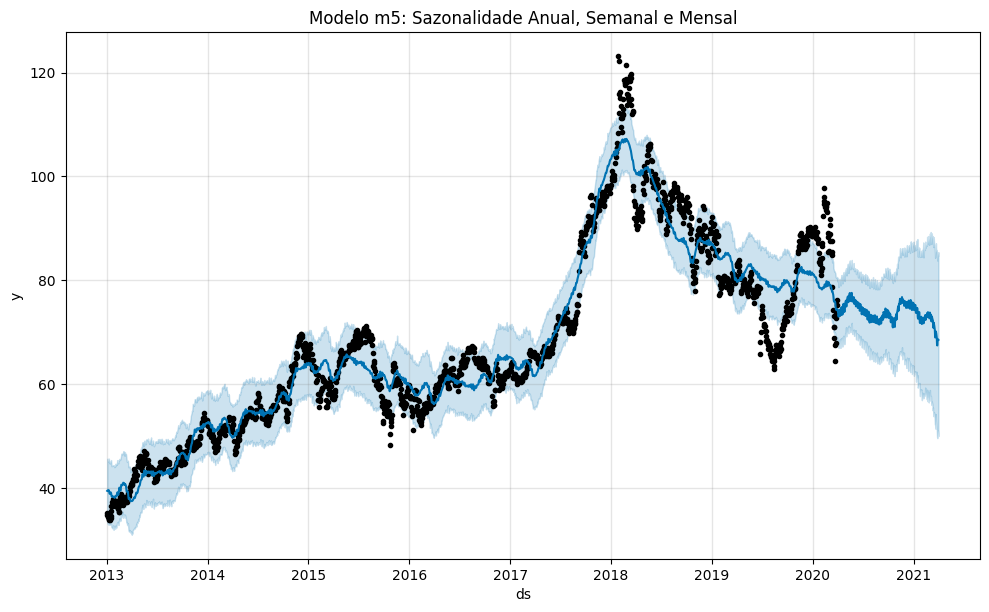

In [19]:
# Ajustando sazonalidade anual e semanal com diferentes fourier_order
m5 = Prophet(
    yearly_seasonality=True,    # sazonalidade anual
    weekly_seasonality=True     # sazonalidade semanal
)
m5.add_seasonality(name='mensal', period=30.5, fourier_order=5)  # Sazonalidade personalizada mensal
forecast_m5 = m5.fit(ts).predict(future)
fig_m5 = m5.plot(forecast_m5)
plt.title('Modelo m5: Sazonalidade Anual, Semanal e Mensal')
plt.show()

## m6

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/frdg_lzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/ux3k49on.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23278', 'data', 'file=/tmp/tmp82pr4_27/frdg_lzg.json', 'init=/tmp/tmp82pr4_27/ux3k49on.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modelfpw3_hoy/prophet_model-20241028002238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


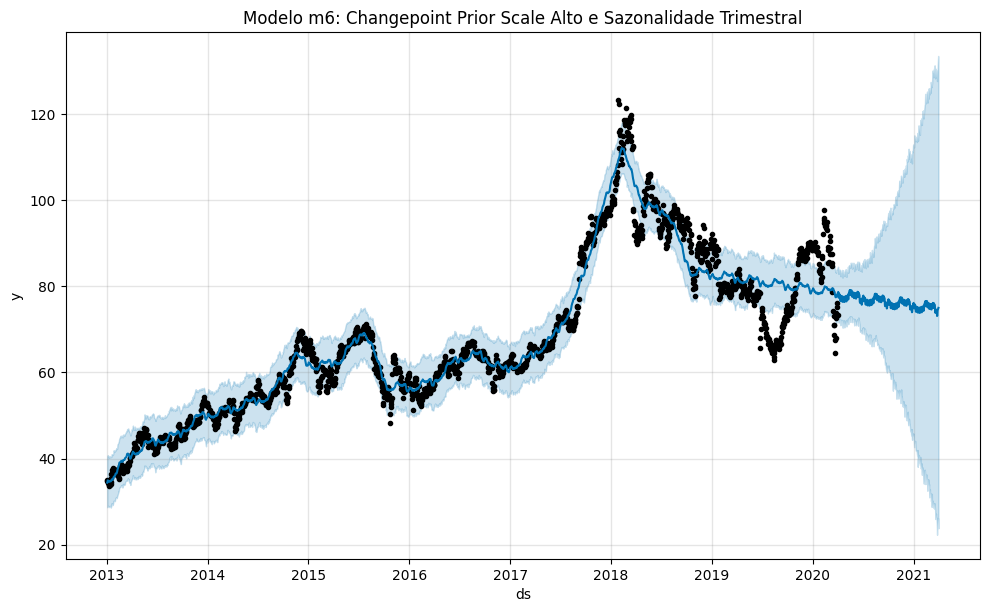

In [20]:
# Changepoint Prior Scale Alto e com sazonalidade trimestral
m6 = Prophet(
    changepoint_prior_scale=0.8,   # Maior sensibilidade a mudanças abruptas
    yearly_seasonality=False       # Desativa sazonalidade anual
)
m6.add_seasonality(name='trimestral', period=91.25, fourier_order=7)  # Sazonalidade trimestral
forecast_m6 = m6.fit(ts).predict(future)
fig_m6 = m6.plot(forecast_m6)
plt.title('Modelo m6: Changepoint Prior Scale Alto e Sazonalidade Trimestral')
plt.show()

## m7

DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/m5cy_riw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/vvq_vch3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35477', 'data', 'file=/tmp/tmp82pr4_27/m5cy_riw.json', 'init=/tmp/tmp82pr4_27/vvq_vch3.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modelbxn8_yye/prophet_model-20241028002436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:24:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:24:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


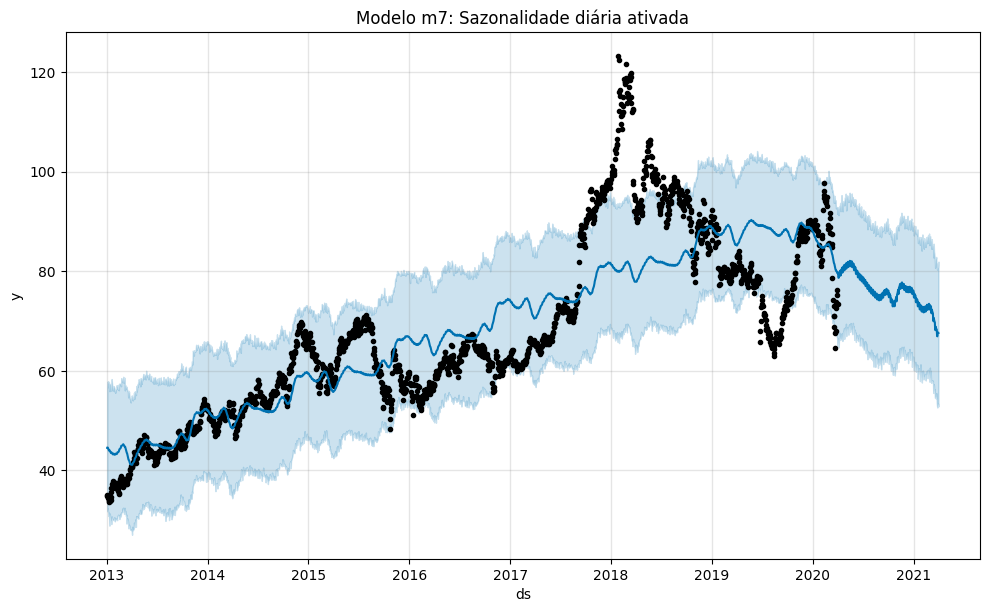

In [22]:
# Changepoints específicos e ajustando holidays
m7 = Prophet(
    changepoints=['2019-08', '2020-01'],
    holidays_prior_scale=0.05,
    daily_seasonality=True  # Ativa sazonalidade diária
)
forecast_m7 = m7.fit(ts).predict(future)
fig_m7 = m7.plot(forecast_m7)
plt.title('Modelo m7: Sazonalidade diária ativada')
plt.show()

# Cross Validation

In [23]:
df_validacao = pd.DataFrame(columns = (['modelo', 'MSE', 'MSE_std']))

## Prophet | Treino 1 ano | Horizon 22 (m0)

In [24]:
from prophet.diagnostics import cross_validation
df_cv_m0 = cross_validation(m0, period='365 days', horizon = '22 days')
display(df_cv_m0.shape)
df_cv_m0

INFO:prophet:Making 7 forecasts with cutoffs between 2014-03-12 00:00:00 and 2020-03-10 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/te0xit8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/pbsab1lz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43388', 'data', 'file=/tmp/tmp82pr4_27/te0xit8b.json', 'init=/tmp/tmp82pr4_27/pbsab1lz.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modelxfq6sx9q/prophet_model-20241028002856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/t5q85sep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/4369zrkb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

(107, 6)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-03-13,51.111586,50.031928,52.106817,51.320000,2014-03-12
1,2014-03-14,51.293289,50.288166,52.242184,51.209999,2014-03-12
2,2014-03-17,51.271245,50.169265,52.245601,51.980000,2014-03-12
3,2014-03-18,51.509704,50.458399,52.523191,53.099998,2014-03-12
4,2014-03-19,51.508075,50.454778,52.536640,53.110001,2014-03-12
...,...,...,...,...,...,...
102,2020-03-26,74.868270,68.488852,80.936895,73.830002,2020-03-10
103,2020-03-27,74.832903,68.766612,80.575804,72.669998,2020-03-10
104,2020-03-30,74.318082,68.330697,81.020066,75.239998,2020-03-10
105,2020-03-31,74.081745,68.018528,79.757196,76.190002,2020-03-10


In [25]:
from prophet.diagnostics import performance_metrics
df_p_m0 = performance_metrics(df_cv_m0)
print('MSE médio: ', df_p_m0.mse.mean())
print('MSE std: ', df_p_m0.mse.std())
print('MSE 22: ', df_p_m0.mse[20])
display(df_p_m0)

new_row = pd.DataFrame([{'modelo': 'Prophet_Treino_365_Horizon_22_m0',
                         'MSE': np.round(df_p_m0.mse.mean(), 2),
                         'MSE_std': np.round(df_p_m0.mse.std(), 2)}])

df_validacao = pd.concat([df_validacao, new_row], ignore_index=True)

df_validacao

MSE médio:  33.8458122230311
MSE std:  26.902355033510055
MSE 22:  56.29567454715758


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,21.400584,4.626077,3.720609,0.042521,0.052321,0.042875,0.40
1,3 days,24.807004,4.980663,4.376954,0.052742,0.054776,0.053758,0.30
2,4 days,19.160470,4.377267,3.893500,0.050400,0.053236,0.051599,0.40
3,5 days,6.897514,2.626312,2.228682,0.033068,0.027880,0.033772,0.60
4,6 days,5.735407,2.394871,2.085842,0.033518,0.032598,0.034166,0.60
5,7 days,7.380942,2.716789,2.552848,0.040289,0.036440,0.040728,0.50
6,8 days,8.618874,2.935792,2.631319,0.039480,0.036440,0.039434,0.60
7,9 days,9.120350,3.019992,2.522014,0.036482,0.033037,0.036137,0.70
8,10 days,13.139762,3.624881,2.972621,0.044074,0.041420,0.043761,0.50
9,11 days,35.437550,5.952945,4.464724,0.060793,0.049132,0.060085,0.40


<ipython-input-25-a649196c1856>:12: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,modelo,MSE,MSE_std
0,Prophet_Treino_365_Horizon_22_m0,33.85,26.9


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



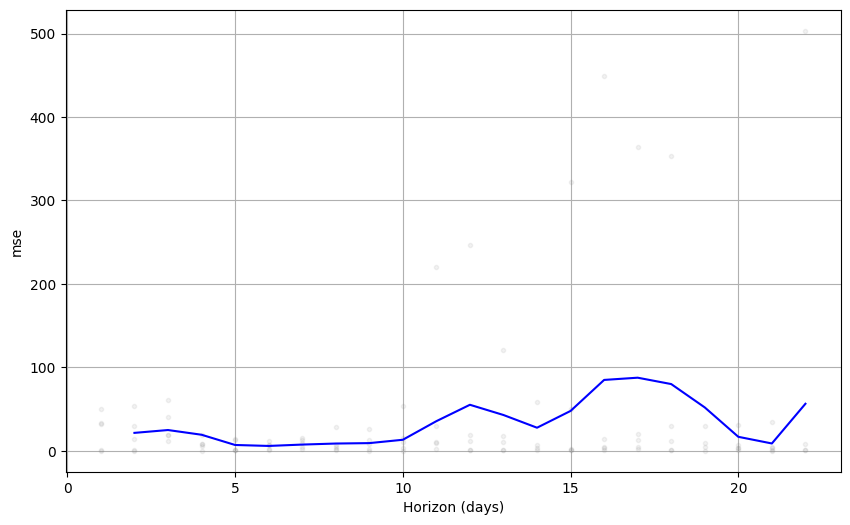

In [26]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv_m0, metric='mse')


## Prophet | Treino 1 ano | Horizon 22 (m1)

INFO:prophet:Making 7 forecasts with cutoffs between 2014-03-12 00:00:00 and 2020-03-10 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/360y2goj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/gc_fz296.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39247', 'data', 'file=/tmp/tmp82pr4_27/360y2goj.json', 'init=/tmp/tmp82pr4_27/gc_fz296.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modelr8lc737q/prophet_model-20241028002900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:29:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:29:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/17k0_5u_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/y4e7pw90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MSE médio:  45.75514640972764
MSE std:  40.93641731027788
MSE 22:  71.45985665411033


,modelo,MSE,MSE_std
0,Prophet_Treino_365_Horizon_22_m0,33.85,26.90
1,Prophet_Treino_365_Horizon_22_m1,45.76,40.94


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



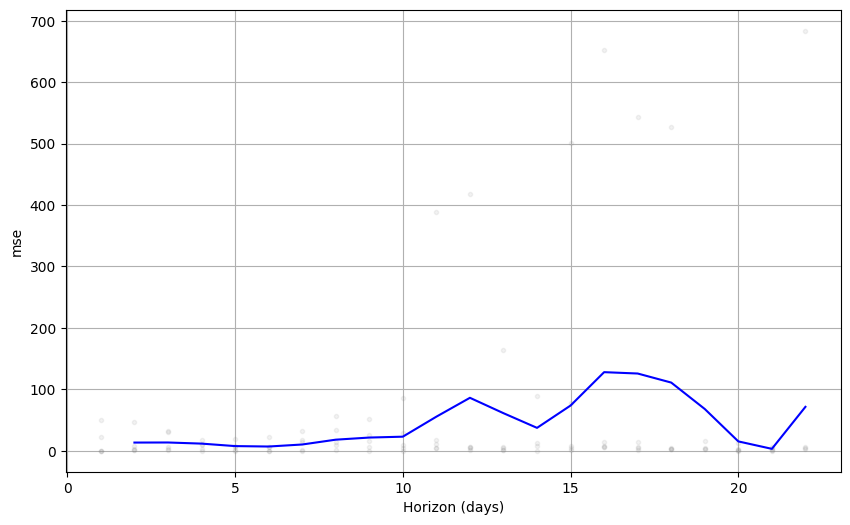

In [27]:
df_cv_m1 = cross_validation(m1, period='365 days', horizon = '22 days')
df_p_m1 = performance_metrics(df_cv_m1)
print('MSE médio: ', df_p_m1.mse.mean())
print('MSE std: ', df_p_m1.mse.std())
print('MSE 22: ', df_p_m1.mse[20])

new_row = pd.DataFrame([{'modelo': 'Prophet_Treino_365_Horizon_22_m1',
                         'MSE': np.round(df_p_m1.mse.mean(), 2),
                         'MSE_std': np.round(df_p_m1.mse.std(), 2)}])

df_validacao = pd.concat([df_validacao, new_row], ignore_index=True)
display(df_validacao)

fig = plot_cross_validation_metric(df_cv_m1, metric='mse')


# Models comparison

In [ ]:
# Função para calcular as métricas (MSE e desvio padrão do MSE)
def calcular_metricas(nome_modelo, y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    mse_std = mse ** 0.5  # Desvio padrão do MSE (raiz quadrada)
    return pd.DataFrame({'modelo': [nome_modelo], 'MSE': [mse], 'MSE_std': [mse_std]})

df_validacao = pd.DataFrame(columns=['modelo', 'MSE', 'MSE_std'])

In [ ]:
# Função Genérica para Criar e Avaliar Modelos ------------
def avaliar_modelo(nome_modelo, modelo, ts):
    # Criando timestamps apenas para o histórico
    future = modelo.make_future_dataframe(periods=0, include_history=True)
    forecast = modelo.predict(future)

    # Filtrando previsões com base nas datas do histórico
    forecast_filtered = forecast[forecast['ds'].isin(ts['ds'])]

    # Calculando métricas e adicionando ao DataFrame de validação
    metrics = calcular_metricas(nome_modelo, ts['y'], forecast_filtered['yhat'])
    return metrics

In [34]:
# M0: Básico
m0 = Prophet()
m0.fit(ts)
df_validacao = pd.concat([df_validacao, avaliar_modelo('m0', m0, ts)], ignore_index=True)

# M1: changepoint_prior_scale = 0.5
m1 = Prophet(changepoint_prior_scale=0.5)
m1.fit(ts)
df_validacao = pd.concat([df_validacao, avaliar_modelo('m1', m1, ts)], ignore_index=True)

# M2: changepoint_prior_scale = 0.99 (mais sensível a mudanças)
m2 = Prophet(changepoint_prior_scale=0.99)
m2.fit(ts)
df_validacao = pd.concat([df_validacao, avaliar_modelo('m2', m2, ts)], ignore_index=True)

# M3: Changepoint específico
m3 = Prophet(changepoints=['2019-08'])
m3.fit(ts)
df_validacao = pd.concat([df_validacao, avaliar_modelo('m3', m3, ts)], ignore_index=True)

# M4: Outro changepoint
m4 = Prophet(changepoints=['2018-01'])
m4.fit(ts)
df_validacao = pd.concat([df_validacao, avaliar_modelo('m4', m4, ts)], ignore_index=True)

# M5: sazonalidade anual ativada
m5 = Prophet(yearly_seasonality=True)
m5.fit(ts)
df_validacao = pd.concat([df_validacao, avaliar_modelo('m5', m5, ts)], ignore_index=True)

# M6: Sazonalidade semanal customizada
m6 = Prophet(weekly_seasonality=False)
m6.add_seasonality(name='weekly_custom', period=7, fourier_order=3)
m6.fit(ts)
df_validacao = pd.concat([df_validacao, avaliar_modelo('m6', m6, ts)], ignore_index=True)

# M7: Holidays e changepoints personalizados
m7 = Prophet(
    changepoints=['2019-08', '2020-03'],
    holidays_prior_scale=0.05  # Penalização menor para feriados
)
m7.fit(ts)
df_validacao = pd.concat([df_validacao, avaliar_modelo('m7', m7, ts)], ignore_index=True)

print('\nValidação dos Modelos:')
display(df_validacao)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/wb7hgq06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/pnnuq1uj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33705', 'data', 'file=/tmp/tmp82pr4_27/wb7hgq06.json', 'init=/tmp/tmp82pr4_27/pnnuq1uj.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_modeld13nsgek/prophet_model-20241028004436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:44:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:44:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-34-d1f1732057a8>:31: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a f


Validação dos Modelos:


,modelo,MSE,MSE_std
0,m0,22.119038,4.703088
1,m1,12.838094,3.583029
2,m2,12.614695,3.551717
3,m3,104.966125,10.245298
4,m4,88.914329,9.429439
5,m5,22.119038,4.703088
6,m6,22.052465,4.696005
7,m7,104.839210,10.239102


In [32]:
df_validacao

,modelo,MSE,MSE_std
0,m0,22.119038,4.703088


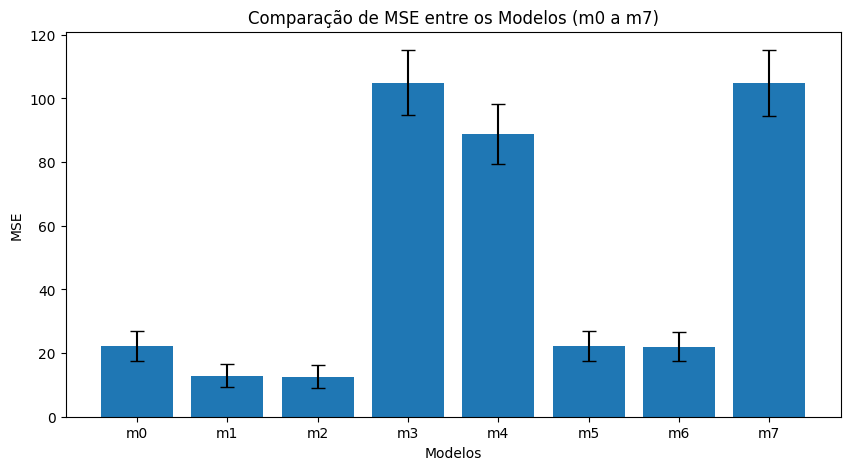

In [35]:
# Plotando o MSE de cada modelo para comparação
plt.figure(figsize=(10, 5))
plt.bar(df_validacao['modelo'], df_validacao['MSE'], yerr=df_validacao['MSE_std'], capsize=5)
plt.title('Comparação de MSE entre os Modelos (m0 a m7)')
plt.xlabel('Modelos')
plt.ylabel('MSE')
plt.show()

# Cross_Validation

INFO:prophet:Making 22 forecasts with cutoffs between 2014-08-01 00:00:00 and 2019-10-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7eb05acb89a0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/g1uuwrku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/zvja2t2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/zky5rnzu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp82pr4_27/1xy53wr7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27505', 'data', 'file=/tmp/tmp82pr4_27/zvja2t2t.json', 'init=/tmp/tmp82pr4_27/zky5rnzu.json', 'output', 'file=/tmp/tmp82pr4_27/prophet_model8jy008pq/prophet_model-20241028004724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:CmdStan args

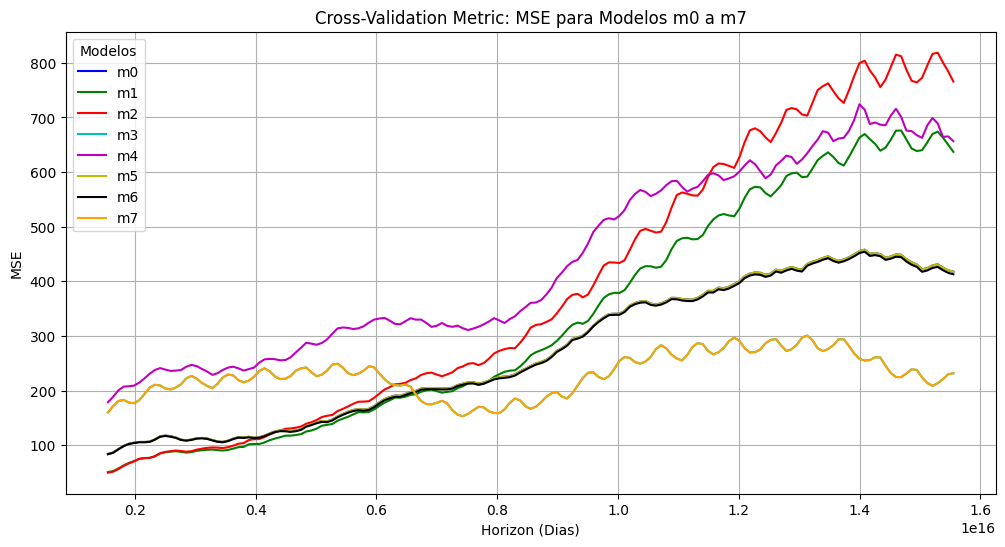

In [36]:
# Dicionário para armazenar previsões e métricas de todos os modelos
modelos = {
    'm0': m0, 'm1': m1, 'm2': m2, 'm3': m3,
    'm4': m4, 'm5': m5, 'm6': m6, 'm7': m7
}

cores = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

plt.figure(figsize=(12, 6))

for i, (nome, modelo) in enumerate(modelos.items()):
    # Métrica de cross-validation (MSE ao longo do tempo)
    from prophet.diagnostics import cross_validation, performance_metrics

    df_cv = cross_validation(modelo, horizon='180 days', period='90 days', parallel="processes")

    # Calculando a métrica de desempenho (MSE)
    df_p = performance_metrics(df_cv, metrics=['mse'])

    # Plotando a curva MSE para o modelo atual
    plt.plot(df_p['horizon'], df_p['mse'], label=nome, color=cores[i])

# Plotando a validação
plt.title('Cross-Validation Metric: MSE para Modelos m0 a m7')
plt.xlabel('Horizon (Dias)')
plt.ylabel('MSE')
plt.legend(title='Modelos', loc='upper left')
plt.grid(True)
plt.show()

# Resultado

O Modelo m2 é o melhor com base no menor MSE (12.61) e na baixa variabilidade das previsões (MSE_std de 3.55).
Ele apresenta uma precisão melhor em suas previsões e uma consistência em relação a como suas previsões se comportam em diferentes cenários de teste. O menor erro quadrático médio (MSE) mostra que as previsões dele estão mais próximas dos valores reais, tornando-o a melhor escolha para aplicações práticas.

O uso de changepoint_prior_scale, permite que o modelo se ajuste de forma flexível às mudanças na tendência, o que pode ser essencial para séries temporais que apresentam variações abruptas.